# Coursework Assignment 2: Measuring Sentence Similarity using MLP

## Setting Up Environment

In [1]:
#Set up for Jupyter Notebook

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
import numpy as np
from torch import nn
import torch
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_data = pd.read_csv('cw2_train.csv')
dev_data = pd.read_csv('cw2_dev.csv')

word_vec_dim = 100
path = "glove.6B.{}d.txt".format(word_vec_dim)
word_vectors = KeyedVectors.load_word2vec_format(path)

/Users/jayasmitachakraborty/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jayasmitachakraborty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Extracting the existing word embeddings from the 100D GloVE embeddings

In [2]:
oov_vec = np.random.rand(word_vec_dim)

def get_sent_word_vecs(word_vectors, sent_words):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

In [4]:
print("Number of Training Samples: ", len(train_data))
print("Number of Test Samples: ", len(dev_data))

Number of Training Samples:  11498
Number of Test Samples:  3000


## Code for training neural model, evaluating and analysing it

---
The data is trained based on the 100 dimensions word embeddings from the GloVe file. 
The test_and_analyse() function returns a dataframe with relevant information for analysis of the correct and incorrect semantic similarity.

Sentence similarity is measured based on a significance threshold having default value of 5%, but can be customized. Significan threshold x% implies that if the difference between the predicted similarity and actual similarity is within x%, then the prediction is considered correct, otherwise incorrect.


In [ ]:
def train(model, data, optimizer):
    model.train()
    train_loss = 0
    for batch, sample in data.sample(frac=1).iterrows():
        s1,s2,target = sample['Sent1'], sample['Sent2'], torch.FloatTensor([sample['SimScore']]).to(device)

        s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
        s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())

        optimizer.zero_grad()
        s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

        prediction = cos(s1_vector, s2_vector)
        loss = loss_criteria(prediction, target)
        train_loss += loss.detach()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss/(batch+1)
    return avg_loss

def test_and_analyse(model, data, significance_threshold=5):
    model.eval()
    test_loss = 0
    analysis = {}

    with torch.no_grad():
        batch_count = 0
        correct = 0
        for batch, sample in data.sample(frac=1).iterrows():
            batch_count += 1
            s1,s2,truth = sample['Sent1'], sample['Sent2'], \
                          torch.FloatTensor([sample['SimScore']]).to(device)                                          
        
            s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
            s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())

            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            prediction = cos(s1_vector, s2_vector)
            test_loss += loss_criteria(prediction, truth)   
            significance = abs(truth.item()-prediction.item())/ (truth.item()+1e-10) * 100

            if significance > significance_threshold:
                if len(analysis)>0:
                    analysis['Sent1'] = analysis['Sent1'] + [s1]
                    analysis['Sent2'] = analysis['Sent2'] + [s2]
                    analysis['Prediction']= analysis['Prediction'] + [prediction.item()]
                    analysis['Truth']= analysis['Truth'] + [truth.item()]
                    analysis['Sent1 Embeddings']= analysis['Sent1 Embeddings'] + [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= analysis['Sent2 Embeddings'] + [s2_embeddings.shape[0]]
                    analysis['Correct'] = analysis['Correct'] + ['False']
                else:
                    analysis['Sent1'] = [s1]
                    analysis['Sent2'] = [s2]
                    analysis['Prediction']= [prediction.item()]
                    analysis['Truth']= [truth.item()]
                    analysis['Sent1 Embeddings']= [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= [s2_embeddings.shape[0]]
                    analysis['Correct'] = ['False']
            else:
                if len(analysis)>0:
                    analysis['Sent1'] = analysis['Sent1'] + [s1]
                    analysis['Sent2'] = analysis['Sent2'] + [s2]
                    analysis['Prediction']= analysis['Prediction'] + [prediction.item()]
                    analysis['Truth']= analysis['Truth'] + [truth.item()]
                    analysis['Sent1 Embeddings']= analysis['Sent1 Embeddings'] + [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= analysis['Sent2 Embeddings'] + [s2_embeddings.shape[0]]
                    analysis['Correct'] = analysis['Correct'] + ['True']
                else:
                    analysis['Sent1'] = [s1]
                    analysis['Sent2'] = [s2]
                    analysis['Prediction']= [prediction.item()]
                    analysis['Truth']= [truth.item()]
                    analysis['Sent1 Embeddings']= [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= [s2_embeddings.shape[0]]
                    analysis['Correct'] = ['True']
                correct+=1

    print("Number of correct predictions: ", correct)
    print("Number of incorrect predictions: ", len(dev_data)-correct)

    avg_loss = test_loss/batch_count
    print('Loss of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item(), pd.DataFrame(analysis)

def test(model, data):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        batch_count = 0
        for batch, sample in data.sample(frac=1).iterrows():
            batch_count += 1
            s1,s2,truth = sample['Sent1'], sample['Sent2'], \
                        torch.FloatTensor([sample['SimScore']]).to(device)                                          

            s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
            s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())

            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            prediction = cos(s1_vector, s2_vector)
            test_loss += loss_criteria(prediction, truth)

    avg_loss = test_loss/batch_count
    print('Loss of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
EPOCHS = 30

## Analysis for Base MLP with 2 hidden layers
1. 2 Fully Connected Layers with 500 nodes in between
2. ReLU activation
---
This model yields average loss around 0.078 when trained over 30 epochs with learing rate = 0.001. Epochs = 20, 30 gives the lowest MSE around 0.07154.

SGD and Adam gives lower loss than other optimizers. L2 Regularization does reduces loss values. Some higher values of weight decay deteriorates model performance and loss increases (as shown in the graph below). 
Lowest Validation MSE using L2 Regularisation:  0.06688457727432251 is for weight = 0.001.
This behaviour of L2 Regularization is similar across optimizers.




In [ ]:
class BaseMLP(nn.Module):
    def __init__(self, embedded_dimension):
        super(BaseMLP, self).__init__()
        self.layer1 = nn.Linear(embedded_dimension, 500)
        self.layer2 = nn.Linear(500, embedded_dimension)
        self.activation = nn.ReLU()
        
        
    def forward(self, sent1, sent2):
        sent1 = torch.mean(torch.FloatTensor(sent1).to(device), dim=0).unsqueeze(0)
        sent2 = torch.mean(torch.FloatTensor(sent2).to(device), dim=0).unsqueeze(0)
        sent1 = self.activation(self.layer1(sent1))
        sent1 = self.activation(self.layer2(sent1))
        sent2 = self.activation(self.layer1(sent2))
        sent2 = self.activation(self.layer2(sent2))

        return sent1, sent2

### Checking Training vs Validation Loss 
---
Significance = 5%, Learning Rate = 0.001, Optimizer = Adam, Activation = ReLU


In [ ]:
#initializing model

model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []
analysis = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss, df = test_and_analyse(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    analysis.append(df)

Epoch:  1
Number of correct predictions:  180
Number of incorrect predictions:  2820
Loss of the method on the dev set: 0.10324015468358994
Epoch:  2
Number of correct predictions:  228
Number of incorrect predictions:  2772
Loss of the method on the dev set: 0.0949094295501709
Epoch:  3
Number of correct predictions:  216
Number of incorrect predictions:  2784
Loss of the method on the dev set: 0.08857528865337372
Epoch:  4
Number of correct predictions:  217
Number of incorrect predictions:  2783
Loss of the method on the dev set: 0.08836646378040314
Epoch:  5
Number of correct predictions:  256
Number of incorrect predictions:  2744
Loss of the method on the dev set: 0.08313341438770294
Epoch:  6
Number of correct predictions:  292
Number of incorrect predictions:  2708
Loss of the method on the dev set: 0.08505965024232864
Epoch:  7
Number of correct predictions:  231
Number of incorrect predictions:  2769
Loss of the method on the dev set: 0.07882535457611084
Epoch:  8
Number of c

While training the models, the data is underfitting. The training loss for models is higher than the dev set loss. In fact, training loss is much much higher. Such models require minimum regularisation.
Loss on the validation set reduces with the epochs. This behaviour is consistent across all models.

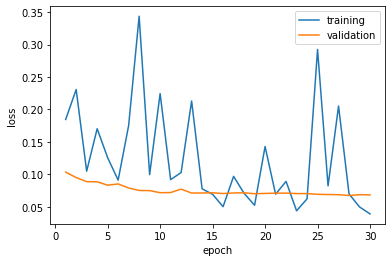

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1,EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Error Analysis

1. th number of word embeddings of the sentences do not affect the errors
2. the difference in the lengths of the 2 setences do not affect the similarity prediction
3. the main factor affecting the errors are the probabilities associated with the centre words:
  - if the centre word of the sentence is not correctly identified
  - if the centre word of the sentence is not present in GloVE embeddings
  - if the centre words of the 2 sentences is differently identified
  - if the associated words in the 2 sentences are different
One possible way to get better predictions would be to remove noise from the sentences. Stopwords when used in certain manner can skew the word embeddings probabilities. Removing stopwords may lead to lower loss because the centre will be easily identified.

CON of this approach: a stop word can easily be the centre word, or important associated words.

In [ ]:
df0 = analysis[29]
df0['Difference in Length'] = (df0['Sent1'].apply(len) - df0['Sent2'].apply(len)).apply(abs)
df0['Difference in Similarity Score'] = (df['Truth']-df['Prediction']).apply(abs)
df0.sort_values(by='Difference in Similarity Score', ascending=False, inplace=True)

In [ ]:
df0[['Sent1', 'Sent2']][0:1]

,Sent1,Sent2
1041,BioReliance's stock closed down 2 cents yester...,Shares of BioReliance sold at $47.98 at the cl...


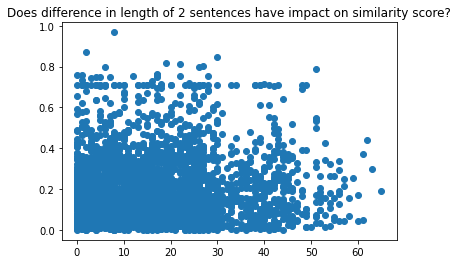

In [ ]:
plt.scatter(df0['Difference in Length'], df0['Difference in Similarity Score'])
plt.title('Does difference in length of 2 sentences have impact on similarity score?')
plt.show()

In [ ]:
df0['Length of Sent1'] = df0['Sent1'].apply(len)
df0['Length of Sent2'] = df0['Sent2'].apply(len)
df0['% Embeddings Sent1'] = (df0['Sent1 Embeddings'] - df0['Length of Sent1']).apply(abs) / df0['Length of Sent1']
df0['% Embeddings Sent2'] = (df0['Sent2 Embeddings'] - df0['Length of Sent2']).apply(abs) / df0['Length of Sent2']

df0[df0['Correct']=='True']

,Sent1,Sent2,Prediction,Truth,Sent1 Embeddings,Sent2 Embeddings,Correct,Difference in Length,Difference in Similarity Score,Length of Sent1,Length of Sent2,% Embeddings Sent1,% Embeddings Sent2
1677,One man is breaking cement on another man's ch...,A man breaks cinder blocks on another man.,0.730944,0.75,9,8,True,8,0.967825,50,42,0.820000,0.809524
1315,A woman is slicing a meat.,A woman is singing on stage.,0.116759,0.05,6,6,True,2,0.872800,26,28,0.769231,0.785714
779,The manager behind the doctors advised the art...,The doctors advised the manager .,0.647739,0.29,9,6,True,19,0.817022,52,33,0.826923,0.818182
1730,The managers fought the athletes .,Before the managers fought the athletes thanke...,0.367580,0.23,6,10,True,27,0.804356,34,61,0.823529,0.836066
1384,The judges introduced the scientist .,Maybe the judges introduced the scientist .,0.727780,0.53,6,7,True,6,0.800000,37,43,0.837838,0.837209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,Students stopped the judge .,Helpful students stopped the judge .,0.761890,0.78,5,6,True,8,0.000107,28,36,0.821429,0.833333
1164,A smiling Caucasian male wearing a blue and bl...,A man in a white shirt and black pants is smil...,0.792695,0.32,17,11,True,44,0.000000,94,50,0.819149,0.780000
2514,The president encouraged the bankers .,The bankers encouraged the president that intr...,0.631271,0.29,6,10,True,27,0.000000,38,65,0.842105,0.846154
508,"There's a geek answer to this, and a practical...",It's pretty ridiculous that I've seen airlines...,0.621214,0.00,12,16,True,25,0.000000,62,87,0.806452,0.816092


### Analysing Effect of Epochs

---

> Higher number of epochs don't always give the best results. 20-30 epochs yield low loss across all models.







In [ ]:
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

epoch_list = [15, 20, 25, 30, 40]
validation_mse = []
for epochs in tqdm(epoch_list):
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.07367449998855591



Loss of the method on the dev set: 0.07154300808906555



Loss of the method on the dev set: 0.07206800580024719



Loss of the method on the dev set: 0.07169400155544281



Loss of the method on the dev set: 0.07304700464010239



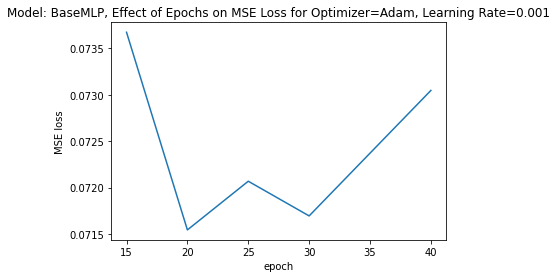

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: BaseMLP, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.001")
plt.show()

In [ ]:
EPOCHS = 20 #epoch_list(np.argmin(np.array(validation_mse)))
print("Epochs for further rounds: ", EPOCHS)

Epochs for further rounds:  20


### Analysing Effect of Learning Rates

In [ ]:
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.07398096472024918



Loss of the method on the dev set: 0.07107064127922058



Loss of the method on the dev set: 0.07120461761951447



Loss of the method on the dev set: 0.07120716571807861



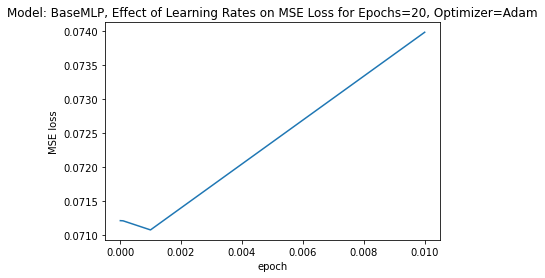

In [ ]:
plt.plot(learning_rates, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Model: BaseMLP, Effect of Learning Rates on MSE Loss for Epochs=20, Optimizer=Adam')
plt.show()

In [ ]:
print("Best Learning Rate: ", learning_rates[np.argmin(np.array(validation_mse))])

Best Learning Rate:  0.001


## Using Base MLP Model with HingeLoss

In [ ]:
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.HingeEmbeddingLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss = test(model, dev_data)


Loss of the method on the dev set: 0.972709059715271


## Analysing Effect of Various Optimizers for MSE Loss 

---
Epochs = 20, Learning Rate = 0.001

In [ ]:
mse_optimizers_BaseMLP = []
learning_rate = 0.001

print('Adam')
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss = test(model, dev_data)
mse_optimizers_BaseMLP.append(test_loss)

print('RMSProp')
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss = test(model, dev_data)
mse_optimizers_BaseMLP.append(test_loss)

print('SGD')
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss = test(model, dev_data)
mse_optimizers_BaseMLP.append(test_loss)

print('Adadelta')
model = BaseMLP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss = test(model, dev_data)
mse_optimizers_BaseMLP.append(test_loss)

Adam



Loss of the method on the dev set: 0.07154154777526855
RMSProp



Loss of the method on the dev set: 0.07207877933979034
SGD



Loss of the method on the dev set: 0.06661505252122879
Adadelta



Loss of the method on the dev set: 0.08121239393949509


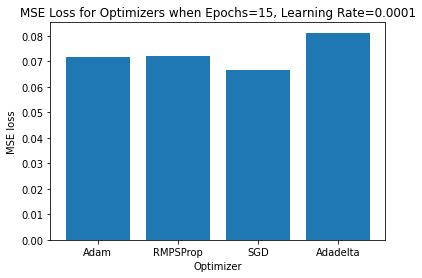

In [ ]:
optimizers= ['Adam', 'RMPSProp', 'SGD', 'Adadelta']
plt.bar(optimizers, mse_optimizers_BaseMLP)
plt.xlabel('Optimizer')
plt.ylabel('MSE loss')
plt.title('MSE Loss for Optimizers when Epochs=20, Learning Rate=0.0001')
plt.show()

## Analysing Effect of L2 Regularization on MLP with 2 Hidden Layers 

---

Optimizer = SGD, Learning Rate = 0.001, Epoch = 20



In [ ]:
weights = [0.001, 0.01, 0.1, 1, 2, 5]
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
cos = nn.CosineSimilarity()
validation_mse = []

for weight in tqdm(weights):
    model = BaseMLP(word_vec_dim)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.06688457727432251



Loss of the method on the dev set: 0.0690050721168518



Loss of the method on the dev set: 0.16047047078609467



Loss of the method on the dev set: 0.3346959948539734



Loss of the method on the dev set: 0.33469611406326294



Loss of the method on the dev set: 0.3346959948539734



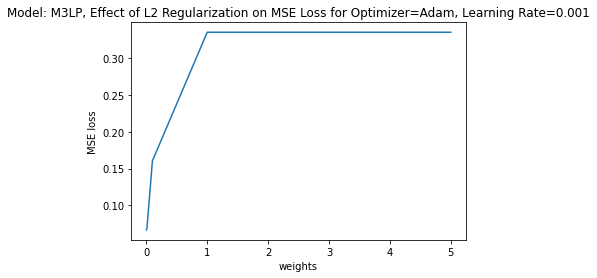

In [ ]:
plt.plot(weights, validation_mse)
plt.xlabel('weights')
plt.ylabel('MSE loss')
plt.title("Model: M3LP, Effect of L2 Regularization on MSE Loss for Optimizer=Adam, Epochw=20, Learning Rate=0.001")
plt.show()

In [ ]:
print("Weight for lowest MSE: ", weights[np.argmin(np.array(validation_mse))])

Weight for lowest MSE:  0.001


In [ ]:
print("Lowest Validation MSE using L2 Regularisation: ", np.min(np.array(validation_mse)))

Lowest Validation MSE using L2 Regularisation:  0.06688457727432251


# Analysis of 3 Layer MLP with Tanh Activation
1. 3 Fully connected layers with nodes 500, 700
2. Tanh Activation
---
Changing the activation function and adding one more layer improves the performance of the model. The average loss for this model across all experimentation is around 0.061.

Analysing 5 different optimizers multiple times shows no real relation between a particular optimizer and low MSE. In the bar graph, ASGD optimizer is having slightly lower loss, but this varies if we run multiple iterations.
Effect of optimizer is minimum for this model.

Epochs = 20, 25 give lower MSE.

Best parameters:
1. Epochs = 25
2. Learning rate = 0.001
3. Optimizer = ASGD/Adam

No regularization has been applied as the training and validation loss curves show that the model is not overfitting the training data.

The lowest loss was achieved with this model = 0.061.

The reduced loss can be due to 2 factors:
1. one extra layer
2. using the Tanh activation

Experimenting with dimensions of the layers has not significantly changed the results.

The loss of the model with different input and output dimensions for the layers varied between 0.060 - 0.080


In [ ]:
class M3LP(nn.Module):
    def __init__(self, embedded_dimension):
        super(M3LP, self).__init__()
        self.layer1 = nn.Linear(embedded_dimension, 500)
        self.layer2 = nn.Linear(500, 700)
        self.layer3 = nn.Linear(700, embedded_dimension)
        self.activation = nn.Tanh()
        
        
    def forward(self, sent1, sent2):
        sent1 = torch.mean(torch.FloatTensor(sent1).to(device), dim=0).unsqueeze(0)
        sent2 = torch.mean(torch.FloatTensor(sent2).to(device), dim=0).unsqueeze(0)
        sent1 = self.activation(self.layer1(sent1))
        sent1 = self.activation(self.layer2(sent1))
        sent1 = self.activation(self.layer3(sent1))
        sent2 = self.activation(self.layer1(sent2))
        sent2 = self.activation(self.layer2(sent2))
        sent2 = self.activation(self.layer3(sent2))

        return sent1, sent2

In [ ]:
model = M3LP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train(model, train_data, optimizer)
test_loss = test(model, dev_data)


Loss of the method on the dev set: 0.0612361840903759


In [ ]:
model = M3LP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
epoch_list = [15, 20, 25, 30, 40]
validation_mse = []

for epochs in tqdm(epoch_list):
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.06340368837118149



Loss of the method on the dev set: 0.06006232649087906



Loss of the method on the dev set: 0.059694476425647736



Loss of the method on the dev set: 0.06113744527101517



Loss of the method on the dev set: 0.061050765216350555



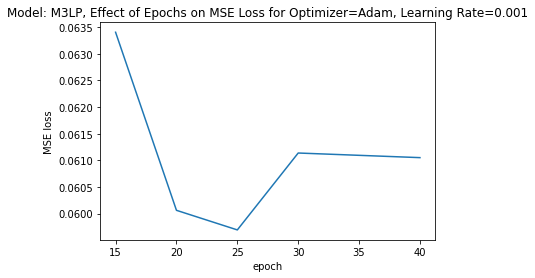

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: M3LP, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.001")
plt.show()

## Checking Effect of Learning Rates

In [ ]:
model = M3LP(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.1395997405052185



Loss of the method on the dev set: 0.1344999074935913



Loss of the method on the dev set: 0.13407598435878754



Loss of the method on the dev set: 0.13403503596782684



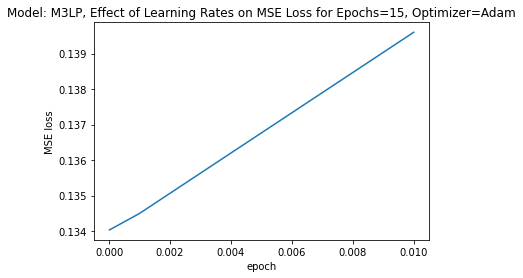

In [ ]:

plt.plot(learning_rates, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Model: M3LP, Effect of Learning Rates on MSE Loss for Epochs=20, Optimizer=Adam')
plt.show()

## Comparing the performance of Optimizers

In [ ]:
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
dispatcher = {  'Adam'      : torch.optim.Adam(model.parameters(), lr=learning_rate),
                'SGD'       : torch.optim.SGD(model.parameters(), lr=learning_rate),
                'RMSprop'   : torch.optim.RMSprop(model.parameters(), lr=learning_rate),
                'Adadelta'  : torch.optim.Adadelta(model.parameters(), lr=learning_rate),
                'ASGD'      : torch.optim.ASGD(model.parameters(), lr=learning_rate)
             }
mse_optimizers_tanh = []
for opt in dispatcher.keys():
    model = M3LP(word_vec_dim)
    model.to(device)
    print(opt)
    optimizer = eval(opt, {'__builtins__':None}, dispatcher)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    mse_optimizers_tanh.append(test_loss)

Adam



Loss of the method on the dev set: 0.25683775544166565
SGD



Loss of the method on the dev set: 0.26007434725761414
RMSprop



Loss of the method on the dev set: 0.25882774591445923
Adadelta



Loss of the method on the dev set: 0.2549273371696472
ASGD



Loss of the method on the dev set: 0.24111804366111755


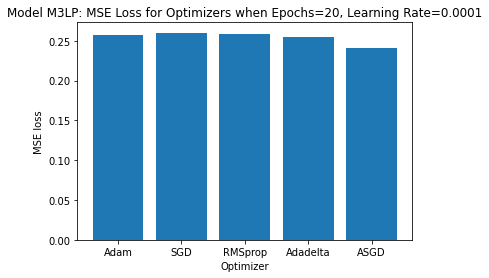

In [ ]:
plt.bar(dispatcher.keys(), mse_optimizers_tanh)
plt.xlabel('Optimizer')
plt.ylabel('MSE loss')
plt.title('Model M3LP: MSE Loss for Optimizers when Epochs=20, Learning Rate=0.0001')
plt.show()

# Analysis with complex MLP

### Complex MLP Architecture 1:
1. 8 Fully Connected Layers
2. 2 dropout layers (with same/diff dropout rates)
3. 2 activation functions - ReLU, Tanh
  Tanh activation applied to layer just before dropout layer

---
Complex neural networks don't always give good results. This model yeilds pretty high loss compared to the model above. Adding dropout layers as a regularization parameter did not have much impact on the loss. 

Experimentation with dropout rates was inconclusive because multiple iterations gave varied results. But dropouts > 0.5 for both dropout layers performed much better than rates < 0.5
Maybe using multiple dense layers requires using higher dropout rates to prevent overfitting the training data. Lower number of fully connected layer would work with lower range of dropout rates.

Loss on this model is always around 0.3, which is much higher than the simpler Tanh Model defined above.

Error Analysis:

The number of incorrect similarity scores based on 5% significance level is much higher. This is expected because the MSE is higher.


In [ ]:
class ComplexMLP(nn.Module):
    def __init__(self, embedded_dimension, dropout_rates):
        super(ComplexMLP, self).__init__()
        self.layer1 = nn.Linear(embedded_dimension, 512)
        self.layer2 = nn.Linear(512, 512)
        self.drop1 = nn.Dropout(dropout_rates[0])
        self.layer3 = nn.Linear(512, 1024)
        self.layer4 = nn.Linear(1024, 864)
        self.layer5 = nn.Linear(864, 864)
        self.layer6 = nn.Linear(864, 256)
        self.drop2 = nn.Dropout(dropout_rates[1])
        self.layer7 = nn.Linear(256, 64)
        self.layer8 = nn.Linear(64, embedded_dimension)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.Tanh()
        
        
    def forward(self, sent1, sent2):
        sent1 = torch.mean(torch.FloatTensor(sent1).to(device), dim=0).unsqueeze(0)
        sent2 = torch.mean(torch.FloatTensor(sent2).to(device), dim=0).unsqueeze(0)

        sent1 = self.activation2(self.layer1(sent1))
        sent1 = self.activation1(self.layer2(sent1))
        sent1 = self.drop1(sent1)
        sent1 = self.activation1(self.layer3(sent1))
        sent1 = self.activation1(self.layer4(sent1))
        sent1 = self.activation1(self.layer5(sent1))
        sent1 = self.activation2(self.layer6(sent1))
        sent1 = self.drop2(sent1)
        sent1 = self.activation1(self.layer7(sent1))
        sent1 = self.activation1(self.layer8(sent1))


        sent2 = self.activation2(self.layer1(sent2))
        sent2 = self.activation1(self.layer2(sent2))
        sent2 = self.drop1(sent2)
        sent2 = self.activation1(self.layer3(sent2))
        sent2 = self.activation1(self.layer4(sent2))
        sent2 = self.activation1(self.layer5(sent2))
        sent2 = self.activation2(self.layer6(sent2))
        sent2 = self.drop2(sent2)
        sent2 = self.activation1(self.layer7(sent2))
        sent2 = self.activation1(self.layer8(sent2))

        return sent1, sent2

## Analysing Effect of Epochs

In [ ]:
model = ComplexMLP(word_vec_dim, [0.2,0.25])
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

epoch_list = [15, 20, 25, 30, 40]
validation_mse = []
for epochs in tqdm(epoch_list):
  for epoch in tqdm(range(1, epochs + 1)):
      train_loss = train(model, train_data, optimizer)
      training_loss.append(train_loss)

  test_loss = test(model, dev_data)
  validation_mse.append(test_loss)


Loss of the method on the dev set: 0.30420130491256714



Loss of the method on the dev set: 0.30420127511024475



Loss of the method on the dev set: 0.3042013645172119



Loss of the method on the dev set: 0.3042014539241791



Loss of the method on the dev set: 0.3042013645172119



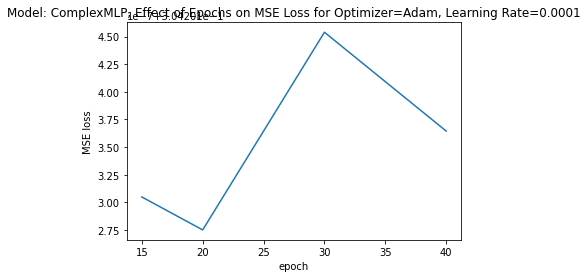

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: ComplexMLP, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.0001")
plt.show()

## Analysing Effect of Learning Rates

In [ ]:
model = ComplexMLP(word_vec_dim, [0.2, 0.25])
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.3042011559009552



Loss of the method on the dev set: 0.3042013645172119



Loss of the method on the dev set: 0.3042011260986328



Loss of the method on the dev set: 0.3042014241218567



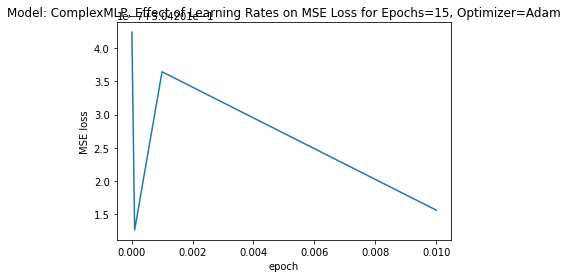

In [ ]:
plt.plot(learning_rates, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP, Effect of Learning Rates on MSE Loss for Epochs=20, Optimizer=Adam')
plt.show()

## Effect of Different Dropout Rates

In [ ]:
dropouts = [[0.1,0.1],
            [0.1, 0.8],
            [0.25,0.25],
            [0.8,0.1],
            [0.5, 0.5],
            [0.8,0.9],
            [0.9,0.8],
            [0.5, 0.8],
            [0.8,0.4]]

cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []

for rates in dropouts:
    model = ComplexMLP(word_vec_dim, rates)
    model.to(device)
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.3041960895061493



Loss of the method on the dev set: 0.3041951060295105



Loss of the method on the dev set: 0.30419647693634033



Loss of the method on the dev set: 0.30419832468032837



Loss of the method on the dev set: 0.30419594049453735



Loss of the method on the dev set: 0.30419641733169556



Loss of the method on the dev set: 0.30419495701789856



Loss of the method on the dev set: 0.3041935861110687



Loss of the method on the dev set: 0.30419501662254333


In [ ]:
print("Best dropout rates: ", dropouts[np.argmin(np.array(validation_mse))])

Best dropout rates:  [0.5, 0.8]


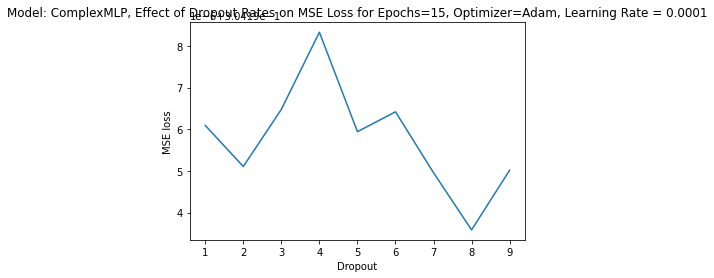

In [ ]:
plt.plot(range(1,len(dropouts)+1), validation_mse)
plt.xlabel('Dropout')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP, Effect of Dropout Rates on MSE Loss for Epochs=20, Optimizer=Adam, Learning Rate = 0.0001')
plt.show()

## Error Analysis

---
Previous outputs of this complexMLP model shows that loss is consistently higher than other simpler models. The Tanh Model gives loss around 0.061.
However, when it comes to prediction accuracy, there are no incorrect predictions at the significance level 5% i.e. we are allowing 5% variation between true label and prediction


In [28]:
model = ComplexMLP(word_vec_dim, [0.2, 0.3])
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, train_data, optimizer)
test_loss, analysis = test_and_analyse(model, dev_data)


Number of correct predictions:  134
Number of incorrect predictions:  2866
Loss of the method on the dev set: 0.3042014539241791


### Error Analysis

1. th number of word embeddings of the sentences do not affect the errors
2. the difference in the lengths of the 2 setences do not affect the similarity prediction
3. the main factor affecting the errors are the probabilities associated with the centre words:
  - if the centre word of the sentence is not correctly identified
  - if the centre word of the sentence is not present in GloVE embeddings
  - if the centre words of the 2 sentences is differently identified
  - if the associated words in the 2 sentences are different
One possible way to get better predictions would be to remove noise from the sentences. Stopwords when used in certain manner can skew the word embeddings probabilities. Removing stopwords may lead to lower loss because the centre will be easily identified.

CON of this approach: a stop word can easily be the centre word, or important associated words.

In [29]:
df1 = analysis

In [31]:
df1.head()

,Sent1,Sent2,Prediction,Truth,Sent1 Embeddings,Sent2 Embeddings,Correct
0,The secretaries danced .,"While the secretaries danced , the scientist i...",1.0,0.61,4,11,False
1,The brown and white cows are eating in the tro...,Brown and white cows are eating from a trough.,1.0,0.96,10,9,True
2,Lawyers advised the athletes .,Serious lawyers advised the athletes .,1.0,0.78,5,6,False
3,A man plays the guitar and sings.,A man is singing and playing a guitar.,1.0,1.00,7,8,True
4,A man is peeling a banana.,A woman is peeling a potato.,1.0,0.28,6,6,False


The prediction of this model are all ones. This is grossly incorrect.

### Complex MLP Architecture 2:
1. 8 Fully Connected Layers
2. 2 Dropout Layers with customisable dropout rates
3. 3 activation functions:
    - ReLU
    - Tanh
    - LeakyReLU

The LeakyReLU activation is applied to the dense layer right after the dropout layer.


---

Experimentation with dropout values is inconclusive. Different iterations yield different optimal values for dropout rates.

Analysing the parameter of Leaky ReLU() we can see that high negative slope lowers the loss to 0.289.

The effect of epochs and learning rate has remained consistent across all models - simple/complex:
 - Learning rate around 0.001-0.001 is optimal. Anything higher than that increases the loss.
 - Epochs = 20-30 gives the best loss value



In [ ]:
class ComplexMLP2(nn.Module):
    def __init__(self, embedded_dimension, dropout_rates, leak):
        super(ComplexMLP2, self).__init__()
        self.layer1 = nn.Linear(embedded_dimension, 512)
        self.layer2 = nn.Linear(512, 512)
        self.drop1 = nn.Dropout(dropout_rates[0])
        self.layer3 = nn.Linear(512, 1024)
        self.layer4 = nn.Linear(1024, 864)
        self.layer5 = nn.Linear(864, 864)
        self.layer6 = nn.Linear(864, 256)
        self.drop2 = nn.Dropout(dropout_rates[1])
        self.layer7 = nn.Linear(256, 64)
        self.layer8 = nn.Linear(64, embedded_dimension)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.Tanh()
        self.activation3 = nn.LeakyReLU(leak)
        
        
    def forward(self, sent1, sent2):
        sent1 = torch.mean(torch.FloatTensor(sent1).to(device), dim=0).unsqueeze(0)
        sent2 = torch.mean(torch.FloatTensor(sent2).to(device), dim=0).unsqueeze(0)

        sent1 = self.activation2(self.layer1(sent1))
        sent1 = self.activation1(self.layer2(sent1))
        sent1 = self.drop1(sent1)
        sent1 = self.activation3(self.layer3(sent1))
        sent1 = self.activation1(self.layer4(sent1))
        sent1 = self.activation1(self.layer5(sent1))
        sent1 = self.activation2(self.layer6(sent1))
        sent1 = self.drop2(sent1)
        sent1 = self.activation3(self.layer7(sent1))
        sent1 = self.activation1(self.layer8(sent1))


        sent2 = self.activation2(self.layer1(sent2))
        sent2 = self.activation1(self.layer2(sent2))
        sent2 = self.drop1(sent2)
        sent2 = self.activation3(self.layer3(sent2))
        sent2 = self.activation1(self.layer4(sent2))
        sent2 = self.activation1(self.layer5(sent2))
        sent2 = self.activation2(self.layer6(sent2))
        sent2 = self.drop2(sent2)
        sent2 = self.activation3(self.layer7(sent2))
        sent2 = self.activation1(self.layer8(sent2))

        return sent1, sent2

## Analysing Effect of Epochs

In [ ]:
model = ComplexMLP2(word_vec_dim, [0.2,0.25], 0.2)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

epoch_list = [15, 20, 25, 30, 40]
validation_mse = []
for epochs in tqdm(epoch_list):
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.30420148372650146



Loss of the method on the dev set: 0.3042011260986328



Loss of the method on the dev set: 0.30420157313346863



Loss of the method on the dev set: 0.3042010962963104



Loss of the method on the dev set: 0.30420148372650146



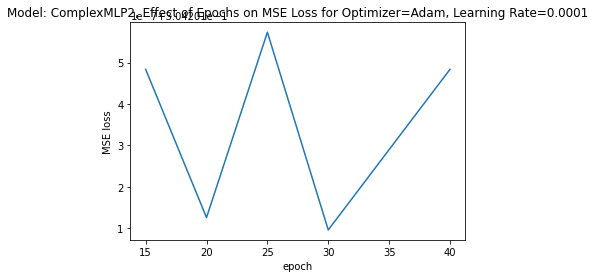

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: ComplexMLP2, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.0001")
plt.show()

## Effect of Learning Rates

In [ ]:
model = ComplexMLP2(word_vec_dim, [0.2, 0.25], 0.2)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates): 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.30420154333114624



Loss of the method on the dev set: 0.3042016625404358



Loss of the method on the dev set: 0.3042013943195343



Loss of the method on the dev set: 0.30420127511024475



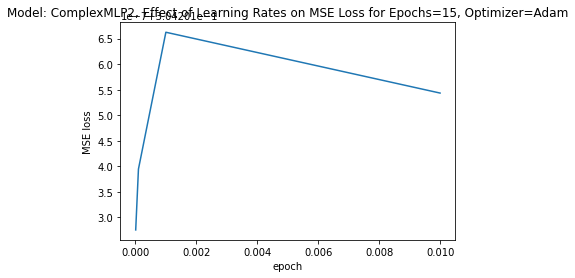

In [ ]:
plt.plot(learning_rates, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP2, Effect of Learning Rates on MSE Loss for Epochs=20, Optimizer=Adam')
plt.show()

## Analyzing Effect of Dropouts

In [ ]:
dropouts = [[0.1,0.1],
            [0.1, 0.8],
            [0.25,0.25],
            [0.8,0.1],
            [0.5, 0.5],
            [0.8,0.9],
            [0.9,0.8],
            [0.5, 0.8],
            [0.8,0.4]]

cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []

for rates in dropouts:
    model = ComplexMLP2(word_vec_dim, rates, 0.2)
    model.to(device)
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.3041968047618866



Loss of the method on the dev set: 0.3041968047618866



Loss of the method on the dev set: 0.30419689416885376



Loss of the method on the dev set: 0.30419597029685974



Loss of the method on the dev set: 0.30419477820396423



Loss of the method on the dev set: 0.30419686436653137



Loss of the method on the dev set: 0.3041975796222687



Loss of the method on the dev set: 0.30419763922691345



Loss of the method on the dev set: 0.3041953444480896


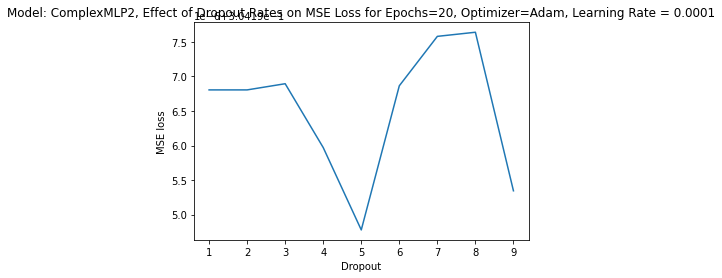

In [ ]:
plt.plot(range(1,len(dropouts)+1), validation_mse)
plt.xlabel('Dropout')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP2, Effect of Dropout Rates on MSE Loss for Epochs=20, Optimizer=Adam, Learning Rate = 0.0001')
plt.show()

In [ ]:
print("Best dropout rates: ", dropouts[np.argmin(np.array(validation_mse))])

Best dropout rates:  [0.5, 0.5]


## Experimenting with different parameters for LeakyReLU()
Larger values of negative slope gives better loss.

In [ ]:
parameters = [0.1, 0.2, 0.8, 1, 1.5, 2, 5, 8, 10, 15]

cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []

for leak in parameters:
    model = ComplexMLP2(word_vec_dim, [0.8,0.9], leak)
    model.to(device)
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


Loss of the method on the dev set: 0.30419835448265076



Loss of the method on the dev set: 0.30419495701789856



Loss of the method on the dev set: 0.30417943000793457



Loss of the method on the dev set: 0.3041796386241913



Loss of the method on the dev set: 0.3041480481624603



Loss of the method on the dev set: 0.3040515184402466



Loss of the method on the dev set: 0.30269986391067505



Loss of the method on the dev set: 0.3000524938106537



Loss of the method on the dev set: 0.29556649923324585



Loss of the method on the dev set: 0.2893228530883789


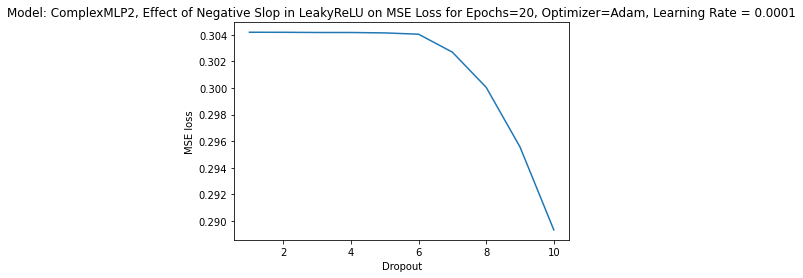

In [ ]:
plt.plot(range(1,len(parameters)+1), validation_mse)
plt.xlabel('Dropout')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP2, Effect of Negative Slop in LeakyReLU on MSE Loss for Epochs=20, Optimizer=Adam, Learning Rate = 0.0001')
plt.show()

In [ ]:
print("Best slope value for LeakyReLU(): ", parameters[np.argmin(np.array(validation_mse))])

Best slope value for LeakyReLU():  15


## Experimenting with Different Optimizers

In [ ]:
model = ComplexMLP2(word_vec_dim, [0.5, 0.5], 15)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
dispatcher = {  'Adam'      : torch.optim.Adam(model.parameters(), lr=learning_rate),
                'SGD'       : torch.optim.SGD(model.parameters(), lr=learning_rate),
                'RMSprop'   : torch.optim.RMSprop(model.parameters(), lr=learning_rate),
                'Adadelta'  : torch.optim.Adadelta(model.parameters(), lr=learning_rate),
                'ASGD'      : torch.optim.ASGD(model.parameters(), lr=learning_rate)
             }
mse_optimizers_complex = []
for opt in dispatcher.keys():
    model = ComplexMLP2(word_vec_dim, [0.5, 0.5], 15)
    model.to(device)
    print(opt)
    optimizer = eval(opt, {'__builtins__':None}, dispatcher)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
          train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    mse_optimizers_complex.append(test_loss)

Adam



Loss of the method on the dev set: 0.28599321842193604
SGD



Loss of the method on the dev set: 0.2939263880252838
RMSprop



Loss of the method on the dev set: 0.2950007915496826
Adadelta



Loss of the method on the dev set: 0.28712132573127747
ASGD



Loss of the method on the dev set: 0.29012608528137207


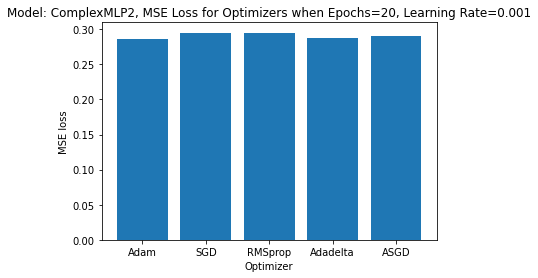

In [ ]:
plt.bar(dispatcher.keys(), mse_optimizers_complex)
plt.xlabel('Optimizer')
plt.ylabel('MSE loss')
plt.title('Model: ComplexMLP2, MSE Loss for Optimizers when Epochs=20, Learning Rate=0.001')
plt.show()

## Applying Batch Processing

---

How Mini-Batch processing was applied:
1. model training and testing done on n number of inputs at a time, where n is the size of the mini batch
2. word embeddings for the first n pair of sentences are concatenated into one list
3. the similarity score of the sentences are averaged to one value

This approach reduces the accuracy of the training data.


---


Batch sizes of 10 greatly improves runtime efficiency. Without batches, the training time of the models for 25-30 epochs is around 10-12 minutes on GPU. When the training is done in mini batches, the training time reduced to 5-7 minutes.

However, the loss increases by a lot. 
For both the simple and complex models and multiple regularization techniques, the loss is around 0.1. Higher loss is because batch processing lowers accuracy of the training data






In [ ]:
def word_vecs_by_batch(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
    return np.array(np.transpose(vecs))

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv =  word_vecs_by_batch(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    return np.array(text_vecs)

In [ ]:
def batch_train(model, data, optimizer, batch_size):
    model.train()
    train_loss = 0
    for i in range(0,len(data),batch_size):

        s1_embeddings = build_mini_batch(data['Sent1'][i:i+batch_size], word_vectors)
        if s1_embeddings.shape[0] == 0: continue 
        s2_embeddings = build_mini_batch(data['Sent2'][i:i+batch_size], word_vectors)
        if s2_embeddings.shape[0] == 0: continue

        target = torch.mean(torch.FloatTensor(list(data['SimScore'][i:i+batch_size])), dim=0).to(device)
        target = torch.reshape(target,(-1,))
        optimizer.zero_grad()
        s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

        prediction = cos(s1_vector, s2_vector)
        loss = loss_criteria(prediction, target)
        train_loss += loss.detach()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss/(i+1)
    return avg_loss

def batch_test(model, data, batch_size):
    model.eval()
    test_loss = 0
    batch = 0

    with torch.no_grad():
        for i in range(0,len(data),batch_size):
            batch+=1
            s1_embeddings = build_mini_batch(data['Sent1'][i:i+batch_size], word_vectors)
            if s1_embeddings.shape[0] == 0: continue
            s2_embeddings = build_mini_batch(data['Sent2'][i:i+batch_size], word_vectors)
            if s2_embeddings.shape[0] == 0: continue

            truth = torch.mean(torch.FloatTensor(list(data['SimScore'][i:i+batch_size])), dim=0).to(device)
            truth = torch.reshape(truth,(-1,))

            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            prediction = cos(s1_vector, s2_vector)
            test_loss += loss_criteria(prediction, truth)

    avg_loss = test_loss/batch
    print('Loss of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item()

In [ ]:
class simpleTanhNet(nn.Module):
    def __init__(self, embedded_dimension):
        super(simpleTanhNet, self).__init__()
        self.layer1 = nn.Linear(embedded_dimension, 500)
        self.layer2 = nn.Linear(500, 700)
        self.layer3 = nn.Linear(700, embedded_dimension)
        self.activation = nn.Tanh()
        
        
    def forward(self, sent1, sent2):
        sent1 = torch.mean(torch.FloatTensor(sent1).to(device), dim=(0,2)).unsqueeze(0)
        sent2 = torch.mean(torch.FloatTensor(sent2).to(device), dim=(0,2)).unsqueeze(0)
        sent1 = self.activation(self.layer1(sent1))
        sent1 = self.activation(self.layer2(sent1))
        sent1 = self.activation(self.layer3(sent1))
        sent2 = self.activation(self.layer1(sent2))
        sent2 = self.activation(self.layer2(sent2))
        sent2 = self.activation(self.layer3(sent2))

        return sent1, sent2

In [ ]:
model = simpleTanhNet(word_vec_dim)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []
training_loss = []

batch_size = 10
EPOCHS = 25
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
test_loss = batch_test(model, dev_data, batch_size)


Loss of the method on the dev set: 0.1127767488360405


## Exporting the BaseCNN model givinh lowest Loss around 0.070

In [ ]:
import pickle

info_to_save = {
    'model_state_dict': model.state_dict(),
    'oov_vec': oov_vec
}

with open('MLP_Classifier.state_dict', 'wb') as ff:
    pickle.dump(info_to_save, ff)